In [4]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

In [5]:
import sys
import os
from datetime import datetime
import numpy as np
import pandas as pd
import json
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pickle as cp
from tensorflow import keras
import tensorflow as tf
from keras import backend as K
import datetime as dt
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

###  Hyperparameters

In [7]:
hidden_units = 100
epochs = 100
lookback = 7
learning_rate = 0.001
batch_size = 1024

crops = ['Onion','Potato','Wheat','Rice']
crop = crops[0]

train_split = 2557 - 1 #if using price diff

fileformat = 'food_price_data/%s.csv'

### Data

In [8]:
def toPDTimeSeries(crop,start,end):
    startdate = dt.datetime.strptime(start, '%Y-%m-%d').date()
    enddate = dt.datetime.strptime(end, '%Y-%m-%d').date()
    data = pd.read_csv(fileformat%(crop))
    print(data.head())
    price = data['price']
    dates = data['date']
    
    dateindex = pd.DatetimeIndex(dates)
    print(dateindex[0]+31)
    print (dateindex)
    price_data = pd.Series(price)#, index=dates)#index)
    return price_data[start:end]
    

In [9]:
def addSpanLag(data, events=[], look_back=7, look_ahead = 7):##span==1
#     ### Adding span (required for weekly, monthly average data)
#     if span>1:
#         nts = []
#         ind = 0
#         while ind < len(ts):
#             tmpts = ts[ind:ind+span]
#             print (tmpts)
#             dt = tmpts[0]
#             vals = [k for k in tmpts]
#             pr = sum(vals)/len(vals)
#             nts.append((dt,pr))
#             ind+=span
#         ts = nts
#     if not convert_to_Xy:
#         return ts

    ### Adding lag (based on look back and look ahead)
    
    if len(events) > 0:
        input = np.append(data,events,axis=1)
    else:
        input = data
    #     season = np.array([k%365 for k in range(train_split)])
    #     season = season.reshape(len(season),1)
    #     input = np.append(input,season,axis=1)
    ind = 0
    X_data = []
    y_data = []

    while ind + look_back + look_ahead < len(data):
        
        X = input[ind:ind+look_back]
        Y = data[ind+look_back+look_ahead]
        X_data.append(X)
        y_data.append(Y)
        ind+=1
    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data

#### Reading food prices

In [10]:
food_price = pd.read_csv(fileformat%(crop))['price']
food_price_diff = food_price.diff().dropna()

#### Reading event embeddings

In [12]:
events_train = np.load('embeddings/events_2006_2012.npy')

#### Rearranging the data (Training)

In [13]:
price_diff_train = np.array(food_price_diff[:train_split]).reshape(train_split,1)

X_event_train, y_event_train    = addSpanLag(price_diff_train,events_train,look_back=7,look_ahead=0)
X_noevent_train,y_noevent_train = addSpanLag(price_diff_train,look_back=7,look_ahead=0)

In [14]:
def ren_train(X, y, hidden_units=100, learning_rate=0.01, epochs=200, batch_size=256):
    model = Sequential()
    model.add(LSTM(hidden_units, activation='relu', input_shape=(X.shape[1], X.shape[-1])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X, y, epochs=epochs, verbose=1)
    plt.plot(history.history['loss'])
    plt.show()
    return model

Epoch 1/100
80/80 [==============================] - 1s 4ms/step - loss: 1366.6580
Epoch 2/100
80/80 [==============================] - 0s 4ms/step - loss: 1207.8881
Epoch 3/100
80/80 [==============================] - 0s 4ms/step - loss: 1117.3438
Epoch 4/100
80/80 [==============================] - 0s 4ms/step - loss: 1057.8916
Epoch 5/100
80/80 [==============================] - 0s 4ms/step - loss: 1025.9750
Epoch 6/100
80/80 [==============================] - 0s 4ms/step - loss: 964.2319
Epoch 7/100
80/80 [==============================] - 0s 4ms/step - loss: 884.6075
Epoch 8/100
80/80 [==============================] - 0s 4ms/step - loss: 828.4954
Epoch 9/100
80/80 [==============================] - 0s 4ms/step - loss: 794.4503
Epoch 10/100
80/80 [==============================] - 0s 4ms/step - loss: 785.2161
Epoch 11/100
80/80 [==============================] - 0s 4ms/step - loss: 823.6738
Epoch 12/100
80/80 [==============================] - 0s 4ms/step - loss: 716.0452
Epoch 13

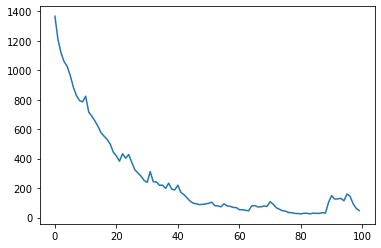

In [55]:
model_noevent = ren_train(X_noevent_train,y_noevent_train,hidden_units=hidden_units,learning_rate=learning_rate,epochs=epochs)


In [2]:
model_noevent.save('models/rnn')

### Testing

#### Reading and rearranging test data



In [17]:
test_price_diff = food_price_diff[train_split:]
test_price_diff = np.array(test_price_diff).reshape(test_price_diff.shape[0],1)


events_test = np.load('embeddings/events.npy')



X_noevent_test, y_noevent_test = addSpanLag(test_price_diff,look_back=7,look_ahead=0)



#### Computing model performance

In [20]:


tr_acc = model_noevent.evaluate(X_noevent_train,y_noevent_train)
tst_acc_13_14 = model_noevent.evaluate(X_noevent_test[:730],y_noevent_test[:730])
yhat=model_noevent.predict(X_noevent_test[:730])
tst_acc = mean_squared_error(yhat,y_noevent_test[:730],squared=False)
print("training accuracy: %.3f\ntest accuracy: %.3f\ntest accuracy 2013-14: %.3f"%(np.sqrt(tr_acc),tst_acc,np.sqrt(tst_acc_13_14)))


23/23 [==============================] - 0s 2ms/step - loss: 5945.4756
training accuracy: 5.322
test accuracy: 77.107
test accuracy 2013-14: 77.107
